# Событийная аналитика в мобильном приложении

## Задача

Исследовать поведение пользователей мобильного приложения. Изучить воронку продаж. Исследовать результаты A/A/B-эксперимента, цель которого — установить влияние на пользователей нового шрифта.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Оглавление

### [Шаг 1. Открытие файла с данными и изучение общей информации](#read_data)
### [Шаг 2. Подготовка данных](#data_preparation)
### [Шаг 3. Изучение и провека данных](#data_checking)
### [Шаг 4. Изучение воронки событий](#funnel_exploration)
### [Шаг 5. Изучение результатов эксперимента](#results)
### [Шаг 6. Общий вывод](#general_conclusion)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import math as mth
import warnings
warnings.simplefilter('ignore')

## <a id='read_data'>Шаг 1. Открытие файла с данными и изучение общей информации</a>

In [2]:
def review_file(filename):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
    '''
    
    table = pd.read_csv(filename, sep='\t')
    
    print('\033[1m'
          + 'Общая информация о таблице:'
          + '\033[0m')
    print()
    table.info()
    print()
    
    print('\033[1m'
          + 'Первые 10 строк таблицы:'
          + '\033[0m')
    display(table.head(10))
        
    print('\033[1m' +
          'Количество пропусков в каждом столбце таблицы:'
          + '\033[0m')
    display(pd.DataFrame(table.isna().sum()))
    
    print('\033[1m'
          + f'Число дубликатов в таблице: {table.duplicated().sum()}'
          + '\033[0m')
    
    return table

In [3]:
logs_exp = review_file('/datasets/logs_exp.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Первые 10 строк таблицы:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Количество пропусков в каждом столбце таблицы:


,0
EventName,0
DeviceIDHash,0
EventTimestamp,0
ExpId,0


Число дубликатов в таблице: 413


### Вывод

Датафрейм **logs_exp** состоит из 244 126 строк и 4 столбцов. Пропусков нет. Обнаружены некорректные типы данных. Обнаружено 413 дубликатов.

## <a id='data_preparation'>Шаг 2. Подготовка данных</a>

#### Заменим названия столбцов таблицы на названия, удобные для анализа.

In [4]:
logs_exp = logs_exp.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'user_id',
    'EventTimestamp': 'event_ts',
    'ExpId': 'exp_id'
})

Причина возникновения 413 дубликатов в данных остаётся неясной. Возможно, причиной служит технический сбой в системе сбора данных.

#### Избавимся от дубликатов.

In [5]:
logs_exp = logs_exp.drop_duplicates()

Хранить идентификаторы в числовом формате нежелательно.

#### Откорректируем типы данных.

In [6]:
logs_exp['user_id'] = logs_exp['user_id'].astype('str')
logs_exp['exp_id'] = logs_exp['exp_id'].astype('str')

#### Добавим столбец даты и времени, а также отдельный столбец дат.

In [7]:
logs_exp['event_time'] = pd.to_datetime(logs_exp['event_ts'], unit='s')
logs_exp['event_date'] = pd.to_datetime(logs_exp['event_time'].dt.date)

### Вывод

Заменены названия столбцов для удобства анализа. Удалены дубликаты. Откорректированы типы данных. Добавлены столбец даты и времени, а также отдельный столбец дат.

## <a id='data_checking'>Шаг 3. Изучение и провека данных</a>

#### Найдём число событий в логе.

In [8]:
logs_exp['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

В логе 5 уникальных событий:
1. Появление главной страницы.
2. Появление страницы с предложениями.
3. Появление страницы с корзиной.
4. Появление страницы с успешной оплатой.
5. Руководство.

#### Найдём число пользователей в логе.

In [9]:
print(f"Всего в логе {logs_exp['user_id'].nunique()} пользователей.")

Всего в логе 7551 пользователей.


#### Найдём среднее число событий, приходящихся на пользователя.

In [10]:
def define_bins(series): 
    if series.max() > 100:
        return 50
    elif series.max() > 500:
        return 100
    elif series.max() > 1000:
        return 200
    else:
        return 20

In [11]:
def draw_hist(series, title, xlabel, draw_lines=True, datetime=False):
    '''
    Функция рисует гистограмму заданного объекта типа Series.
    
    Аргументы:
        series (pandas.core.series.Series): объект типа Series.
        
        title (str): заголовок гистограммы.
        
        xlabel (str): подпись оси абсцисс.
        
        draw_lines (bool): нарисовать медиану, 5-ый и 95-ый перцентили.
        
        datetime (bool): индикатор типа данных datetime.
    '''
    
    # Определяем число корзин
    # Если данные имеют тип datetime
    if datetime:
        # Устанавливаем значение 100
        bins = 100
        # На всём отрезке
        range = (series.min(), series.max())
        # С поворотом чисел на отметках абсциссы
        labelrotation = 45
    # Иначе
    else:
        # Определяем оптимальное число корзин
        bins = define_bins(series)
        # Определяем отрезок от 0 до 99-го перцентиля
        range = (0, series.quantile(.99))
        # Не поворачивая числа на отметках абсциссы
        labelrotation = 0
    
    # Создаём фигуру
    plt.figure(figsize=(15, 6))
    # Строим гистограмму
    plt.hist(series,                                 # по Series
             range=range,                            # на определённом отрезке
             bins=bins,                              # с определённым числом корзин
             alpha=0.5,                              # с прозрачностью 0.5
             ec='black',                             # с чёрным цветом обводки
             color='green')                          # с зелёным цветом графика
    # Если необходимо нарисовать нарисовать медиану, 5-ый и 95-ый перцентили
    if draw_lines:
        plt.axvline(x=series.median(),               # рисуем медиану
                    linewidth=3,                     # с толщиной линий 3
                    color='red',                     # красного цвета
                    linestyle='--')                  # пунктирным стилем
        plt.axvline(x=series.quantile(.05),          # рисуем 5-ый перцентиль
                    linewidth=3, 
                    color='y',                       # тёмно-жёлтого цвета
                    linestyle='--')
        plt.axvline(x=series.quantile(.95),          # рисуем 95-ый перцентиль
                    linewidth=3, 
                    color='y', 
                    linestyle='--')
        # Добавляем легенду
        plt.legend(labels=['Медиана', '5-ый и 95-ый перцентили'], fontsize=15)
    # Увеличиваем числа на отметках осей
    plt.tick_params(labelsize=15)
    # Задаём угол поворота чисел на абсциссе
    plt.tick_params(labelrotation=labelrotation, axis='x')
    # Добавляем заголовок
    plt.title(title, fontsize=15)
    # Добавляем подпись оси абсцисс
    plt.xlabel(xlabel, fontsize=15)
    # Добавляем подпись оси ординат
    plt.ylabel('Число наблюдений', fontsize=15)
    # Рисуем сетку
    plt.grid()
    # Рисуем график
    plt.show()

In [12]:
events_per_user = logs_exp.groupby('user_id').agg({'event_name': 'count'})

#### Взглянем на распределение числа событий, приходящихся на пользователя.

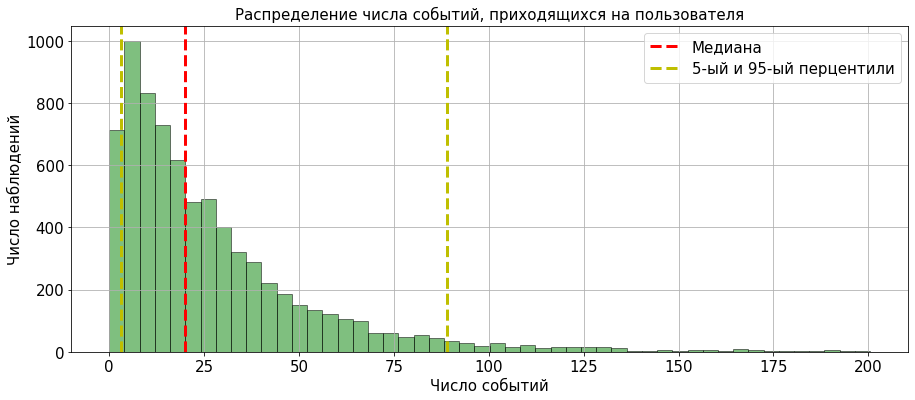

In [13]:
draw_hist(
    events_per_user['event_name'], 
    'Распределение числа событий, приходящихся на пользователя', 
    'Число событий'
)

In [14]:
print(
    'Среднее число событий, приходящихся на пользователя: '
    + f'{(events_per_user.mean()[0]):.2f}.'
)

Среднее число событий, приходящихся на пользователя: 32.28.


Так как распределение числа событий, приходящихся на пользователя, не является нормальным и содержит выбросы, разумнее будет использовать медиану.

In [15]:
print(
    'Медианное число событий, приходящихся на пользователя: '
    + f'{events_per_user.median()[0]}.'
)

Медианное число событий, приходящихся на пользователя: 20.0.


#### Определим, данными за какой период мы располагаем.

In [16]:
logs_exp['event_time'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_time, dtype: object

Располагаем данными за период с 25 июля по 7 августа 2019 года.

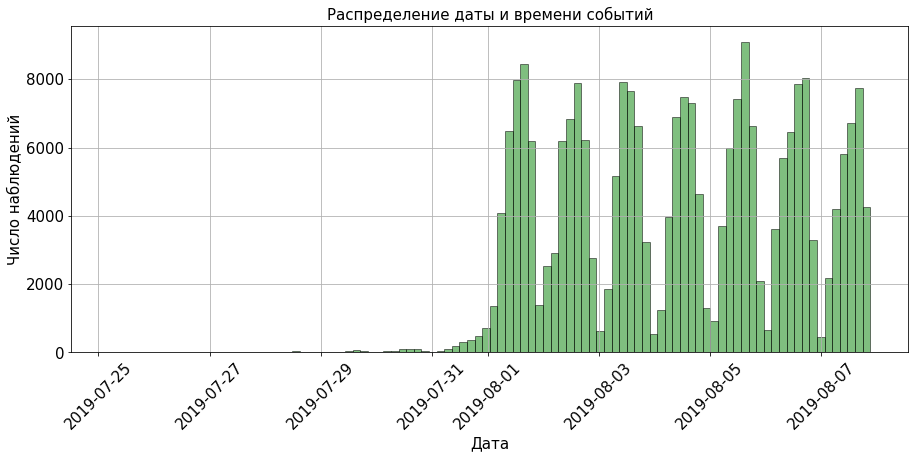

In [17]:
draw_hist(
    logs_exp['event_time'], 
    'Распределение даты и времени событий', 
    'Дата', 
    draw_lines=False, 
    datetime=True
)

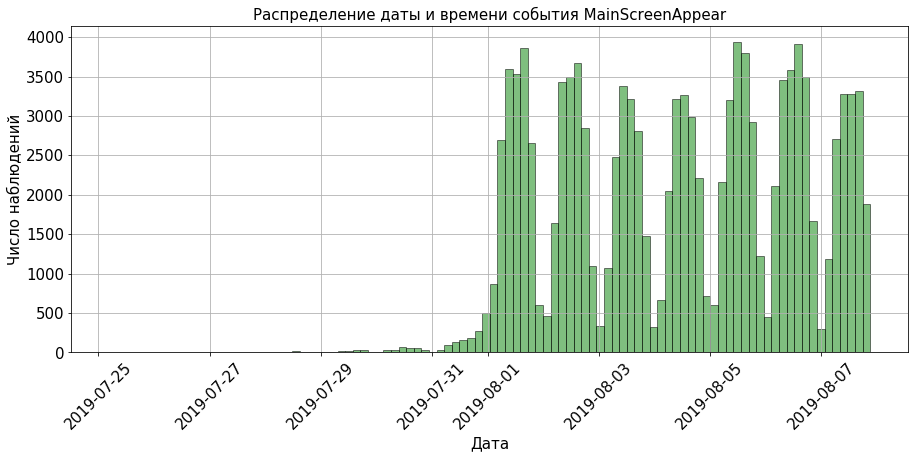

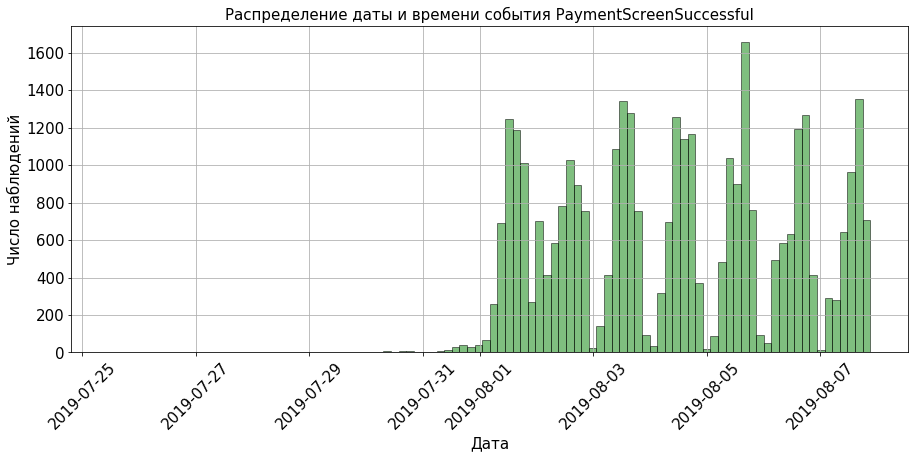

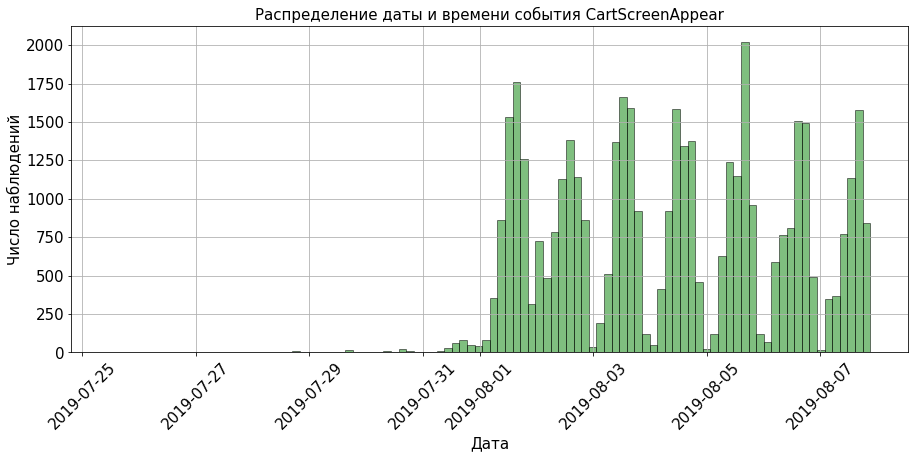

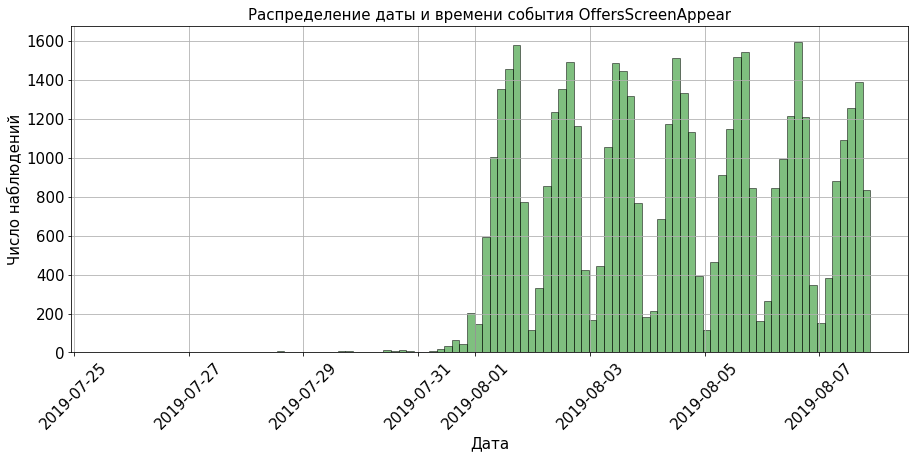

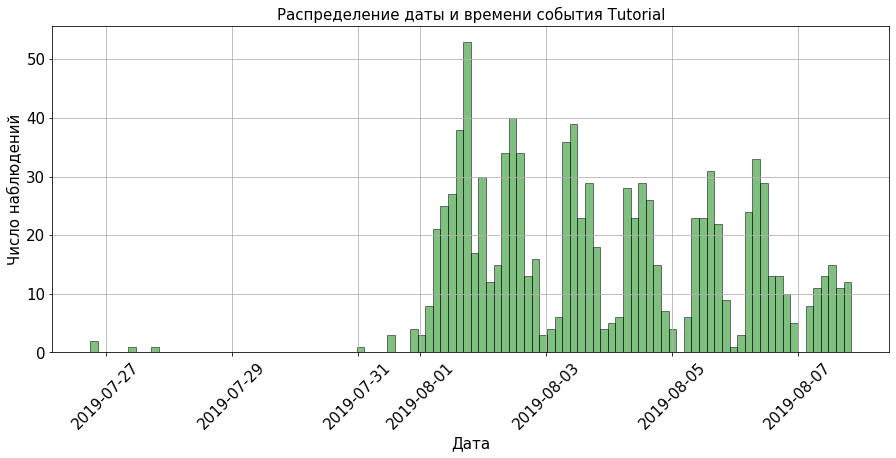

In [18]:
for name in logs_exp['event_name'].unique():
    draw_hist(
        logs_exp.query('event_name == @name')['event_time'],
        f'Распределение даты и времени события {name}',
        'Дата',
        draw_lines=False, 
        datetime=True
    )

Оказалось, что данные до августа 2019 года являются неполными. Полагаю, эксперимент начался 1 августа.

#### Отбросим неполные данные.

In [19]:
comp_data = logs_exp.query('event_date >= "2019-08-01"')

Таким образом, на самом деле мы располагаем данными за период с 1 по 7 августа 2019 года.

#### Найдём число и долю потерянных событий после отброса старых данных.

In [20]:
print(f'Потеряно {logs_exp.shape[0] - comp_data.shape[0]} событий.')

Потеряно 2826 событий.


In [21]:
print(
    'Потеряно '
    + f'{((logs_exp.shape[0] - comp_data.shape[0]) / logs_exp.shape[0]):.2%} '
    + 'событий.'
)

Потеряно 1.16% событий.


Отбросив данные, мы потеряли незначительную их часть (2 826 или 1.16% событий).

#### Найдём число и долю потерянных пользователей после отброса старых данных.

In [22]:
print(
    'Потеряно '
    + f"{logs_exp['user_id'].nunique() - comp_data['user_id'].nunique()} "
    + 'пользователей.'
)

Потеряно 17 пользователей.


In [23]:
print(
    'Потеряно '
    + '{:.2%} '
    .format(
        (logs_exp['user_id'].nunique() - comp_data['user_id'].nunique()) 
        / logs_exp['user_id'].nunique()
    )
    + 'пользователей.'
)

Потеряно 0.23% пользователей.


Доля потерянных пользователей составляет 0.23% (17 пользователей). 

#### Проверим корректность разделения пользователей по группам.

In [24]:
group_a1 = comp_data.query('exp_id == "246"')
group_a2 = comp_data.query('exp_id == "247"')
group_b = comp_data.query('exp_id == "248"')

display(
    group_a1['user_id'].isin(group_a2['user_id']).value_counts(),
    group_a1['user_id'].isin(group_b['user_id']).value_counts(),
    group_a2['user_id'].isin(group_b['user_id']).value_counts()
)

False    79302
Name: user_id, dtype: int64

False    79302
Name: user_id, dtype: int64

False    77022
Name: user_id, dtype: int64

Распределение пользователей по группам выполнено корректно.

#### Проверим, что в данных присутствуют пользователи их всех трёх эксперементальных групп.

In [25]:
comp_data.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


In [26]:
comp_data.groupby('exp_id').agg({'user_id': 'nunique'})['user_id'].sum() + 17

7551

В данных присутствуют пользователи их всех трёх эксперементальных групп.

### Вывод

В логе 5 уникальных событий:
1. Появление главной страницы.
2. Появление страницы с предложениями.
3. Появление страницы с корзиной.
4. Появление страницы с успешной оплатой.
5. Руководство.

Всего в логе 7551 пользователей.

Среднее число событий, приходящихся на пользователя: 32.

Так как распределение числа событий, приходящихся на пользователя, не является нормальным и содержит выбросы, разумнее будет использовать медиану.

Медианное число событий, приходящихся на пользователя: 20.

Располагаем данными за период с 25 июля по 7 августа 2019 года. Однако данные до августа 2019 года являются неполными. Решено учитывать только полные данные в дальнейшем исследовании. Таким образом, на самом деле мы располагаем данными за период с 1 по 7 августа 2019 года.

Отбросив данные, мы потеряли незначительную их часть (2 826 или 1.16% событий). Доля потерянных пользователей составляет 0.23% (17 пользователей).

Распределение пользователей по группам выполнено корректно. В данных присутствуют пользователи их всех трёх эксперементальных групп.

## <a id='funnel_exploration'>Шаг 4. Изучение воронки событий</a>

#### Посмотрим, какие события есть в логах и как часто они встречаются.

In [27]:
comp_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Как было отмечено выше, в логе всё те же 5 событий с логичной закономерностью частот появлений.

#### Посчитаем, сколько пользователей совершали каждое из событий.

In [28]:
event_funnel = (
    comp_data
    .groupby('event_name', as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={
        'user_id': 'user_amount'
    })
)

event_funnel.loc[5] = ['Visit', comp_data['user_id'].nunique()]

event_funnel = (
    event_funnel
    .sort_values(by='user_amount', ascending=False)
    .reset_index(drop=True)
)

event_funnel

,event_name,user_amount
0,Visit,7534
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,CartScreenAppear,3734
4,PaymentScreenSuccessful,3539
5,Tutorial,840


#### Найдём долю пользователей, которые хоть раз совершали событие.

In [29]:
event_funnel['conversion'] = (
    round(
        event_funnel['user_amount'] / event_funnel['user_amount'][0],
        2
    )
)

event_funnel

,event_name,user_amount,conversion
0,Visit,7534,1.00
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
3,CartScreenAppear,3734,0.50
4,PaymentScreenSuccessful,3539,0.47
5,Tutorial,840,0.11


Предположительно события происходят в порядке *MainScreenAppear* $\rightarrow$ *OffersScreenAppear* $\rightarrow$ *CartScreenAppear* $\rightarrow$ *PaymentScreenSuccessful*. Руководство пользователь, скорее всего, читает лишь единожды и это событие не влечёт за собой череду остальных событий, оканчивающихся покупкой. Поэтому не будем учитывать это событие при исследовании воронки.

#### Исключим событие *Tutorial* из воронки событий.

In [30]:
event_funnel = event_funnel.query('event_name != "Tutorial"')

#### Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [31]:
next_step_ratio = [1.]

for index in range(1, len(event_funnel['user_amount'])):
    next_step_ratio.append(
        event_funnel['user_amount'][index] / event_funnel['user_amount'][index - 1]
    )
        
event_funnel['next_step_ratio'] = np.round(next_step_ratio, 2)

event_funnel

,event_name,user_amount,conversion,next_step_ratio
0,Visit,7534,1.00,1.00
1,MainScreenAppear,7419,0.98,0.98
2,OffersScreenAppear,4593,0.61,0.62
3,CartScreenAppear,3734,0.50,0.81
4,PaymentScreenSuccessful,3539,0.47,0.95


Больше всего пользователей теряется при переходе с главной страницы на страницу с предложениями (36% от пользователей, увидевших главную страницу). 81% оставшихся пользователей добавляют товар в корзину. Лишь 5% пользователей, добавивших товар в корзину, не совершают покупок.

Полностью воронку проходит 47% пользователей.

### Вывод

Как было отмечено выше, в логе всё те же 5 событий с логичной закономерностью частот появлений.

Предположительно события происходят в порядке *MainScreenAppear* $\rightarrow$ *OffersScreenAppear* $\rightarrow$ *CartScreenAppear* $\rightarrow$ *PaymentScreenSuccessful*. Руководство пользователь читает лишь единожды и это событие не влечёт за собой череду остальных событий, оканчивающихся покупкой. Поэтому не будем учитывать это событие при исследовании воронки.

Больше всего пользователей теряется при переходе с главной страницы на страницу с предложениями (36% от пользователей, увидевших главную страницу). 81% оставшихся пользователей добавляют товар в корзину. Лишь 5% пользователей, добавивших товар в корзину, не совершают покупок.

Полностью воронку проходит 47% пользователей.

## <a id='results'>Шаг 5. Изучение результатов эксперимента</a>

#### Найдём количество пользователей в каждой экспериментальной группе.

In [32]:
sizes = comp_data.groupby('exp_id').agg({'user_id': 'nunique'})
sizes

,user_id
exp_id,
246,2484
247,2513
248,2537


In [33]:
size_a1 = sizes['user_id'][0]
size_a2 = sizes['user_id'][1]
size_b = sizes['user_id'][2]

#### Сформируем воронки по группам.

In [34]:
sep_funnel = (
    comp_data
    .pivot_table(
        index='event_name',
        columns='exp_id',
        values='user_id', 
        aggfunc='nunique'
    )
    .sort_values(
        by='246', 
        ascending=False
    )
    .query('event_name != "Tutorial"')
    .reset_index()
)

sep_funnel['246 U 247'] = sep_funnel['246'] + sep_funnel['247']
sep_funnel

exp_id,event_name,246,247,248,246 U 247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [35]:
def z_test(successes_a, trials_a, successes_b, trials_b, alpha=.05):
    '''
    Функция решает задачу сравнения пропорций двух 
    генеральных совокупностей по выборкам из них 
    с помощью Z-критерия.
    
    Аргументы:
        successes_a (int): "успехи" выборки A.
        
        trials_a (int): размер выборки A.
        
        successes_b (int): "успехи" выборки B.
        
        trials_b (int): размер выборки B.
        
        alpha (float): критический уровень статистической значимости.
    '''
    
    # пропорция успехов в первой группе
    p1 = successes_a / trials_a
    # пропорция успехов во второй группе
    p2 = successes_b / trials_b
    # пропорция успехов в комбинированном датасете
    p_combined = (successes_a + successes_b) / (trials_a + trials_b)
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в стандартных отклонениях 
    # стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials_a + 1 / trials_b)
    )
    
    # задаем стандартное нормальное распределение 
    # (среднее 0, стандартное отклонение 1)
    distr = st.norm(0, 1)
    
    # Так как распределение статистики нормальное, вызовем метод cdf(). 
    # Саму статистику возьмём по модулю методом abs() — чтобы получить 
    # правильный результат независимо от её знака. Это возможно, 
    # потому что тест двусторонний. По этой же причине удваиваем результат.
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'p-значение = {(p_value):.3f}.')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, '
            + 'нет оснований считать доли разными.'
        )

In [36]:
def hypothesis_testing(sep_funnel, name_a, name_b, 
                       trials_a, trials_b, alpha=.05):
    '''
    Функция проверяет гипотезу о равенстве долей пользователей,
    совершивших событие, в двух группах.
    
    Аргументы:
        sep_funnel (pandas.core.frame.DataFrame): воронка событий.
        
        name_a (str): название первой группы.
        
        name_b (str): название второй группы.
        
        trials_a (int): размер первой группы.
        
        trials_b (int): размер второй группы.
        
        alpha (float): критический уровень статистической 
                       значимости для Z-критерия.
    '''
    
    if name_a == 'A1':
        id_a = '246'
    elif name_a == 'A2':
        id_a = '247'
    elif name_a == 'B':
        id_a = '248'
    elif name_a == 'A':
        id_a = '246 U 247'
    else:
        raise Exception('Неверное название первой группы. '
        + 'Возможные значения: "A1", "A2", "B", "A".')
        
    if name_b == 'A1':
        id_b = '246'
    elif name_b == 'A2':
        id_b = '247'
    elif name_b == 'B':
        id_b = '248'
    elif name_b == 'A':
        id_b = '246 U 247'
    else:
        raise Exception('Неверное название второй группы. '
        + 'Возможные значения: "A1", "A2", "B", "A".')
        
    for index in range(0, len(sep_funnel)):
        print('\033[1m'
              + 'H0: Доли пользователей, совершивших событие '
              + f"{sep_funnel['event_name'][index]}, "
              + f'равны в группах {name_a} и {name_b}.'
              + '\033[0m'
             )

        print('\033[1m'
              + 'H1: Доли пользователей, совершивших событие '
              + f"{sep_funnel['event_name'][index]}, "
              + f'не равны в группах {name_a} и {name_b}.'
              + '\033[0m'
             )
        
        print(
            f'Доля в группе {name_a} = '
            f'{(sep_funnel[id_a][index] / trials_a):.2%}.'
        )
        
        print(
            f'Доля в группе {name_b} = '
            f'{(sep_funnel[id_b][index] / trials_b):.2%}.'
        )
        
        z_test(
            sep_funnel[id_a][index], 
            trials_a, 
            sep_funnel[id_b][index], 
            trials_b, 
            alpha
        )
        
        print()

#### Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [37]:
hypothesis_testing(sep_funnel, 'A1', 'A2', size_a1, size_a2)

H0: Доли пользователей, совершивших событие MainScreenAppear, равны в группах A1 и A2.
H1: Доли пользователей, совершивших событие MainScreenAppear, не равны в группах A1 и A2.
Доля в группе A1 = 98.63%.
Доля в группе A2 = 98.53%.
p-значение = 0.757.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие OffersScreenAppear, равны в группах A1 и A2.
H1: Доли пользователей, совершивших событие OffersScreenAppear, не равны в группах A1 и A2.
Доля в группе A1 = 62.08%.
Доля в группе A2 = 60.49%.
p-значение = 0.248.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие CartScreenAppear, равны в группах A1 и A2.
H1: Доли пользователей, совершивших событие CartScreenAppear, не равны в группах A1 и A2.
Доля в группе A1 = 50.97%.
Доля в группе A2 = 49.26%.
p-значение = 0.229.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0:

Статистические критерии не находят разницу между контрольными группами $A_1$ и $A_2$.

***

#### Проверим, находят ли статистические критерии разницу между выборками 246 и 248.

In [38]:
hypothesis_testing(sep_funnel, 'A1', 'B', size_a1, size_b)

H0: Доли пользователей, совершивших событие MainScreenAppear, равны в группах A1 и B.
H1: Доли пользователей, совершивших событие MainScreenAppear, не равны в группах A1 и B.
Доля в группе A1 = 98.63%.
Доля в группе B = 98.27%.
p-значение = 0.295.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие OffersScreenAppear, равны в группах A1 и B.
H1: Доли пользователей, совершивших событие OffersScreenAppear, не равны в группах A1 и B.
Доля в группе A1 = 62.08%.
Доля в группе B = 60.35%.
p-значение = 0.208.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие CartScreenAppear, равны в группах A1 и B.
H1: Доли пользователей, совершивших событие CartScreenAppear, не равны в группах A1 и B.
Доля в группе A1 = 50.97%.
Доля в группе B = 48.48%.
p-значение = 0.078.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пол

Статистические критерии не находят разницу между группами $A_1$ и $B$.

***

#### Проверим, находят ли статистические критерии разницу между выборками 247 и 248.

In [39]:
hypothesis_testing(sep_funnel, 'A2', 'B', size_a2, size_b)

H0: Доли пользователей, совершивших событие MainScreenAppear, равны в группах A2 и B.
H1: Доли пользователей, совершивших событие MainScreenAppear, не равны в группах A2 и B.
Доля в группе A2 = 98.53%.
Доля в группе B = 98.27%.
p-значение = 0.459.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие OffersScreenAppear, равны в группах A2 и B.
H1: Доли пользователей, совершивших событие OffersScreenAppear, не равны в группах A2 и B.
Доля в группе A2 = 60.49%.
Доля в группе B = 60.35%.
p-значение = 0.920.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие CartScreenAppear, равны в группах A2 и B.
H1: Доли пользователей, совершивших событие CartScreenAppear, не равны в группах A2 и B.
Доля в группе A2 = 49.26%.
Доля в группе B = 48.48%.
p-значение = 0.579.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пол

Статистические критерии не находят разницу между группами $A_2$ и $B$.

***

In [40]:
hypothesis_testing(sep_funnel, 'A', 'B', size_a1 + size_a2, size_b)

H0: Доли пользователей, совершивших событие MainScreenAppear, равны в группах A и B.
H1: Доли пользователей, совершивших событие MainScreenAppear, не равны в группах A и B.
Доля в группе A = 98.58%.
Доля в группе B = 98.27%.
p-значение = 0.294.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие OffersScreenAppear, равны в группах A и B.
H1: Доли пользователей, совершивших событие OffersScreenAppear, не равны в группах A и B.
Доля в группе A = 61.28%.
Доля в группе B = 60.35%.
p-значение = 0.434.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователей, совершивших событие CartScreenAppear, равны в группах A и B.
H1: Доли пользователей, совершивших событие CartScreenAppear, не равны в группах A и B.
Доля в группе A = 50.11%.
Доля в группе B = 48.48%.
p-значение = 0.182.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

H0: Доли пользователе

Статистические критерии не находят разницу между группами $A_1 \cup A_2 = A$ и $B$.

***

При проверке статистических гипотез выше был использован уровень значимости 0.05. Было осуществлено 16 проверок статистических гипотез. При уровне значимости 0.05 каждый 20-ый раз можно получать ложный результат, поэтому понижать уровень значимости не имеет смысла.

Таким образом, эксперимент показал, что различия в конверсиях контрольных и тестовой групп не являются статистически значимыми. Следовательно, менеджерам не стоит бояться, что пользователям будет непривычно, если дизайнеры поменяют шрифты во всём приложении.

### Вывод

Статистические критерии не находят разницу между контрольными группами $A_1$ и $A_2$.

Статистические критерии не находят разницу между группами $A_1$ и $B$.

Статистические критерии не находят разницу между группами $A_2$ и $B$.

Статистические критерии не находят разницу между группами $A_1 \cup A_2 = A$ и $B$.

При проверке статистических гипотез выше был использован уровень значимости 0.05. Было осуществлено 16 проверок статистических гипотез. При уровне значимости 0.05 каждый 20-ый раз можно получать ложный результат, поэтому понижать уровень значимости не имеет смысла.

Таким образом, эксперимент показал, что различия в конверсиях контрольных и тестовой групп не являются статистически значимыми. Следовательно, менеджерам не стоит бояться, что пользователям будет непривычно, если дизайнеры поменяют шрифты во всём приложении.

## <a id='general_conclusion'>Шаг 6. Общий вывод</a>

Датафрейм **logs_exp** состоит из 244 126 строк и 4 столбцов. Пропусков нет. Обнаружены некорректные типы данных. Обнаружено 413 дубликатов.

Заменены названия столбцов для удобства анализа. Удалены дубликаты. Откорректированы типы данных. Добавлены столбец даты и времени, а также отдельный столбец дат.

В логе 5 уникальных событий с логичной закономерностью частот появлений:
1. Появление главной страницы.
2. Появление страницы с предложениями.
3. Появление страницы с корзиной.
4. Появление страницы с успешной оплатой.
5. Руководство.

Всего в логе 7551 пользователей.

Среднее число событий, приходящихся на пользователя: 32.

Так как распределение числа событий, приходящихся на пользователя, не является нормальным и содержит выбросы, разумнее будет использовать медиану.

Медианное число событий, приходящихся на пользователя: 20.

Располагаем данными за период с 25 июля по 7 августа 2019 года. Однако данные до августа 2019 года являются неполными. Решено учитывать только полные данные в дальнейшем исследовании. Таким образом, на самом деле мы располагаем данными за период с 1 по 7 августа 2019 года.

Отбросив данные, мы потеряли незначительную их часть (2 826 или 1.16% событий). Доля потерянных пользователей составляет 0.23% (17 пользователей).

Распределение пользователей по группам выполнено корректно. В данных присутствуют пользователи их всех трёх эксперементальных групп.

Предположительно события происходят в порядке *MainScreenAppear* $\rightarrow$ *OffersScreenAppear* $\rightarrow$ *CartScreenAppear* $\rightarrow$ *PaymentScreenSuccessful*. Руководство пользователь читает лишь единожды и это событие не влечёт за собой череду остальных событий, оканчивающихся покупкой. Поэтому не будем учитывать это событие при исследовании воронки.

**Больше всего пользователей теряется при переходе с главной страницы на страницу с предложениями (36% от пользователей, увидевших главную страницу)**. 81% оставшихся пользователей добавляют товар в корзину. Лишь 5% пользователей, добавивших товар в корзину, не совершают покупок.

**Полностью воронку проходит 47% пользователей**.

Статистические критерии не находят разницу между контрольными группами $A_1$ и $A_2$.

Статистические критерии не находят разницу между группами $A_1$ и $B$.

Статистические критерии не находят разницу между группами $A_2$ и $B$.

Статистические критерии не находят разницу между группами $A_1 \cup A_2 = A$ и $B$.

При проверке статистических гипотез выше был использован уровень значимости 0.05. Было осуществлено 16 проверок статистических гипотез. При уровне значимости 0.05 каждый 20-ый раз можно получать ложный результат, поэтому понижать уровень значимости не имеет смысла.

Таким образом, эксперимент показал, что различия в конверсиях контрольных и тестовой групп не являются статистически значимыми. Следовательно, менеджерам **не стоит бояться, что пользователям будет непривычно, если дизайнеры поменяют шрифты** во всём приложении.